18-100 Lab 10: Machine Learning

This lab is the starter code for the Machine Learning Lab. Please read through it to get a general understanding of what it does. But, you don't need to write any code, unless you want to.

Instead, once you have a sense as to what the code is doing, you can focus your attention on parameterizing the neural network and training process. To do this, you probably want to focus on the section labelled, "These parameters control some parameters of the neural network and its training".

Please see the lab write up for more detail.



In [ ]:
# This needs to be done once for each newly connected/allocated session.
# It can be skipped after that via "Runtime-->Run [beginning with and] after"
# Or, it can be commented in and out, as needed.

# Install required libraries
!pip install tensorflowjs
!pip install tensorflow==2.15
!pip install tensorflow_decision_forests==1.8.1


In [ ]:
# These parameters control different aspects of the neural network and its training

# These are the parameters you most likely want to explore
TRAIN_SIZE=20                 # This is the total pool of examples presentable to the network for training
BATCH_SIZE=5                  # This is the total number of examples the network should look at before making adjustments
EPOCHS=30                     # This is the number of epochs, i.e. batches of the training set

HIDDEN_LAYERS=1               # The number of densely hidden layers within the neural network
HIDDEN_LAYER_SIZE=64          # The number of neurons in each dense layer. For simplicity, each dense layer is set up to be the same

LEARNING_RATE_COEFF=1.30      # Control the rate at which adjustments to weights are made: <1 slows, 1 is default, and >1 exaggerates

# Feel free to change this, if you'd like, but doing so may not be particularly illuminating for this lab
TEST_SIZE=100                 # This is the number of never-seen-before images used to evaluate the performance after training is complete. Do not lower this number to improve your results.

In [ ]:
# Imports to bring in libraries we need and sometimes give them shorthand aliases

import sys
import numpy
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
#import tensorflow_docs.plots
import tensorflow as tf
import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras import utils
from keras.callbacks import LearningRateScheduler
from google.colab import files

print("Python version:", sys.version)
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)
# Load the TensorBoard notebook extension so we can visualize the netowrk and its training
%load_ext tensorboard

In [ ]:
# load data
# This uses a method, e.g. code, provided with the data set
# It automatically loads both training and validation <image, label> tuples
(training_images, training_labels), (validation_images, validation_labels) = mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# This limits the amount of data we use from each of the training and test sets to
# the amount requested by the parameters provided for you to edit.

training_images = training_images[0:TRAIN_SIZE]
training_labels = training_labels[0:TRAIN_SIZE]
validation_images = validation_images[0:TEST_SIZE]
validation_labels = validation_labels[0:TEST_SIZE]

print (training_images.shape)
print (validation_images.shape)

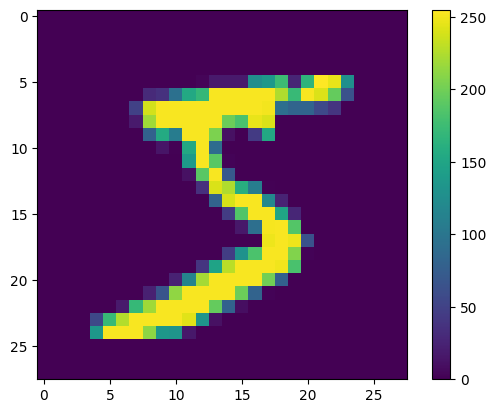

Label: 5


In [ ]:
# This shows us an example of what an image lookes like
plt.figure()                                 # Create a new empty figure
plt.imshow(training_images[0])               # Load the image into the figure
plt.colorbar()                               # Add a color bar to the right of the figure to show the range of colors
plt.grid(False)                              # Don't draw a graph paper -like grid
plt.show()                                   # Display the image on the screen
print ("Label: " + str(training_labels[0]))  # Put a text caption on the image to show its given "ground truth" label

In [ ]:
# Normalize inputs from 0-255 to 0.0-1.0
# In other words divide every pixel by 255 so the range is from 0-1 instead of 0-255
# This is because the neural netowrk expects inputs to be in the range from 0-1
training_images = training_images / 255
validation_images = validation_images / 255

In [ ]:
# Goes through the same process as above to redisplay the image.
# Note that the color bar is now 0.0-1.0
plt.figure()
plt.imshow(training_images[0])
plt.colorbar()
plt.grid(False)
plt.show()
print ("Label: " + str(training_labels[0]))

In [ ]:
# Convert numerical labels to "One-Hot Encoding"
# This means we encode each category's values as a separate boolean output variable
# So,instead of having one output encoded as 0:0/255, 1:1/255, 2:2/255, etc,
# each category gets a different output, so for example, consider 0, 1, and 2:
# 0: {1, 0, 0}
# 1: {0, 1, 0}
# 2: {0, 0, 1}
# This is important to do because There is no numerical relationship between the
# categories. In other word, a 1.5 wouldn't mean half "1" and half "2". It would
# just be hard to interpret and not good for training.
number_of_classes = 10
training_labels = utils.to_categorical(training_labels, number_of_classes)
validation_labels = utils.to_categorical(validation_labels, number_of_classes)

In [ ]:
# Define the architecture of the neural network model

# Define the model sequentially, layer by layer
model = Sequential()

# Add input layer, flattening out the 28x28 2D image into a 1D vector on its way into the network
model.add(Flatten())

# Add hidden layer(s)
# A dense layer is trhe basic fully connected later.
# "relu" is a "rectified linear unit", which is a long way of saying it makes anything negative into a 0
# There isn't such a thing as a negative color, so inhibition (negative weight) isn't likely to be helpful.
for dense_layer in range (HIDDEN_LAYERS):
  model.add(Dense(HIDDEN_LAYER_SIZE, activation='relu'))

# Add output layer
# The output layer is "softmax", which basically means that it takes the
# various outputs and makes them sum up to 1.0, so that they can be interpreted sort of like probabilities
# rather than us having to look at the whole set to interpret how much stronger or weaker one output is than others
model.add(Dense(number_of_classes, activation='softmax'))

In [ ]:
# Compile model
# This is, in some ways, like compiling a program. It takes the model above from a definiton to a usable instance

# Categorical cross-entropy is a way of measuring error in situations where, as is the case with one-hot encoding, outputs are boolean and indicate membership in a single category
# The "adam" optimizer is a form of gradient descent, i.e. a way for the network to assign blame for error and adjust weights by back propogation
# Accuracy is a metric that measures the correctness of the categorization
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
# Create a log directory where the neural network can store data for later visualization by TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up "callback" so that model.fit feeds data into the log diretory for TensorBoard as it trains
# Note that this initializes the callback with the log directory created above and will log with each epoch, i.e. histogram_freq = 1
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



In [ ]:
# Fit, a.k.a. train, the model

def custom_learning_rate(epoch, lrate):
	return LEARNING_RATE_COEFF*lrate

lrs_callback = LearningRateScheduler(custom_learning_rate)
model.fit(training_images, training_labels, validation_data=(validation_images, validation_labels), epochs=EPOCHS, shuffle=True, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,lrs_callback])


In [ ]:
# Start TensorBoard so we can visualize how the training unfolded
# Be patient. You may have a blank window for up to 1-2 minutes (or, possibly more) while the TensorBoard processes the log files and prepares the visualizations
# Set "Smoothing" to 0.0 so that you see the data.
# Fee free to uncheck old runs (or run the cell that comes later to delete them)
%tensorboard --logdir logs/fit

In [ ]:
# Get the final validation loss and accuracy as a simple "score", so you know how you did
metrics = model.evaluate(validation_images, validation_labels, verbose=0)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

In [ ]:
# Save the model so it can be used again without needing to retrain
model.save('handwriting.h5')

In [ ]:
# Convert model for use via a Web page.
!mkdir model                                                          # Make a directory for the model, it is okay to ignore the error if it already exists
!tensorflowjs_converter --input_format keras handwriting.h5 model/    # Convert the model and put it into the directory

In [ ]:
# Archive the model directory into a .zip file for easy downloading
# Uncomment this when instructed in the lab handout.
#!zip -r handwriting.zip model

In [ ]:
# Uncomment the lines below to download the .zip archive of the model from co-lab onto own computer for eventual upload to Web page.
#from google.colab import files
#files.download('handwriting.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Uncomment the line below and run this cell if you'd like to delete all of your existing tensor flow logs.
#!rm -rf ./logs/

# You can also modify the line above to delete only certain logs by adding the date-stamped subdirectory using the date-stamp from TensorBoard, e.g.
#!rm -rf ./logs/fit/20201123-023901/train/                   # Training logs from a particular run
#!rm -rf ./logs/fit/20201123-023901/validation/              # Validation logs from a particular run
#!rm -rf ./logs/fit/20201123-023901/                         # Both training and validation logs from a particular run

CREDITS:

The code below is based upon the following blog:

*   https://blog.tanka.la/2018/05/27/handwritten-digit-prediction-using-convolutional-neural-networks-in-tensorflow-with-keras-and-live-example-using-tensorflow-js/


It was updated to save and download models as shown here:

*   https://blog.tensorflow.org/2018/07/train-model-in-tfkeras-with-colab-and-run-in-browser-tensorflowjs.html

And, inspired by the link below, updated to show metrics for underfit and overfit:
*   https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

Those metrics, however, were ultimately implemented with TensorBoard based upon the link below:
*   https://www.tensorflow.org/tensorboard/get_started

The architecture was also simplified to be more accessible based upon this:
*   https://www.tensorflow.org/tutorials/keras/classification
